# Basic Setup

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Make plots look nice
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

print("Imports done.")


Imports done.


# Setting working directory

In [2]:
current_dir = os.getcwd()
print("Current working directory:", current_dir)

basename = os.path.basename(current_dir).lower()

if basename == "notebooks":
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

print("Assumed project root:", project_root)

# Path to the BERT-augmented dataset
data_path = os.path.join(project_root, "data", "processed", "reviews_with_sentiment.csv")
print("Loading data from:", data_path)

df = pd.read_csv(data_path)
print("Shape:", df.shape)
df.head()


Current working directory: c:\Users\yamis\OneDrive\Desktop\KAIM\Week2\Customer_Experience_Analutics\Customer-Experience-Analytics\notebooks
Assumed project root: c:\Users\yamis\OneDrive\Desktop\KAIM\Week2\Customer_Experience_Analutics\Customer-Experience-Analytics
Loading data from: c:\Users\yamis\OneDrive\Desktop\KAIM\Week2\Customer_Experience_Analutics\Customer-Experience-Analytics\data\processed\reviews_with_sentiment.csv
Shape: (1800, 16)


,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source,sentiment_raw_label_bert,sentiment_raw_score_bert,sentiment_label_bert,sentiment_score_bert
0,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,2025,11,BOA,Bank of Abyssinia,Yohanis Fikadu,0,8,Google Play,POSITIVE,0.999841,positive,0.999841
1,63f63b8b-016a-4262-a27e-f0de9ebf985a,ok,5,2025-11-27,2025,11,BOA,Bank of Abyssinia,Butu Mare,0,2,Google Play,POSITIVE,0.999785,positive,0.999785
2,f28a3a3c-eb94-4aab-88d2-89bcecebcc7b,bad exprience...it is so crushed,1,2025-11-27,2025,11,BOA,Bank of Abyssinia,ሻንበል ኪዳነ,0,32,Google Play,NEGATIVE,0.999805,negative,-0.999805
3,4ed89e8c-16dc-4763-94ca-04d05cf799a5,not user friendly at all it requires a huge co...,1,2025-11-26,2025,11,BOA,Bank of Abyssinia,Tsegaw Fikru,0,85,Google Play,NEGATIVE,0.999766,negative,-0.999766
4,f5bfd792-bc81-4d06-99c9-06c7743d3e09,ምንም የማይ ሰራ,1,2025-11-26,2025,11,BOA,Bank of Abyssinia,Elsa Tesfay,0,10,Google Play,NEGATIVE,0.833725,negative,-0.833725


# VADER lexicon Download & Initalization

In [3]:
# Download VADER lexicon (only first time; safe to run again)
nltk.download('vader_lexicon')

# Initialize VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
print("VADER SentimentIntensityAnalyzer ready.")

VADER SentimentIntensityAnalyzer ready.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yamis\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Text Cleaning 

In [4]:
text_col = "review"
if text_col not in df.columns:
    for cand in ["review_text", "content", "text"]:
        if cand in df.columns:
            text_col = cand
            break

print("Using text column:", text_col)

df["clean_text"] = df[text_col].fillna("").astype(str).str.lower()
df[["bank_code", "rating", text_col, "clean_text"]].sample(10)


Using text column: review_text


,bank_code,rating,review_text,clean_text
926,CBE,5,absolutely excellent,absolutely excellent
1490,DASHEN,5,amazing product,amazing product
788,CBE,5,good,good
76,BOA,5,very good app i ever used,very good app i ever used
1297,DASHEN,5,Astonishing interface with ease of access and ...,astonishing interface with ease of access and ...
953,CBE,1,Redmi,redmi
69,BOA,5,😎,😎
1394,DASHEN,3,very slow,very slow
1773,DASHEN,5,it is very good app,it is very good app
575,BOA,2,After update it doesn't work well,after update it doesn't work well


# Sentiment Analysis

## TextBlob Analysis

In [5]:
# Polarity in [-1, 1], subjectivity in [0, 1]

def tb_polarity(text):
    return TextBlob(text).sentiment.polarity

def tb_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

print("Computing TextBlob polarity and subjectivity...")
df["tb_polarity"] = df["clean_text"].apply(tb_polarity)
df["tb_subjectivity"] = df["clean_text"].apply(tb_subjectivity)

# Converting polarity → sentiment label
def polarity_to_label(p):
    if p > 0.1:
        return "positive"
    elif p < -0.1:
        return "negative"
    else:
        return "neutral"

df["tb_sentiment"] = df["tb_polarity"].apply(polarity_to_label)

df[["bank_code", "rating", "tb_polarity", "tb_subjectivity", "tb_sentiment"]].sample(10)


Computing TextBlob polarity and subjectivity...


,bank_code,rating,tb_polarity,tb_subjectivity,tb_sentiment
1371,DASHEN,5,0.800000,0.750000,positive
1512,DASHEN,5,1.000000,0.300000,positive
1476,DASHEN,1,0.600000,0.900000,positive
501,BOA,5,0.800000,0.750000,positive
36,BOA,1,0.000000,0.500000,neutral
868,CBE,5,0.600000,1.000000,positive
1224,DASHEN,1,0.051667,0.508333,neutral
1552,DASHEN,5,0.100000,1.000000,neutral
1722,DASHEN,5,0.215096,0.432918,positive
1420,DASHEN,2,0.361111,0.513889,positive


## VADER Analysis

In [6]:
def vader_compound(text):
    return sia.polarity_scores(text)["compound"]

print("Computing VADER compound scores...")
df["vader_compound"] = df["clean_text"].apply(vader_compound)

# Standard VADER thresholds:
# compound >= 0.05 → positive
# compound <= -0.05 → negative
# otherwise → neutral
def vader_label(c):
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

df["vader_sentiment"] = df["vader_compound"].apply(vader_label)

df[["bank_code", "rating", "tb_polarity", "vader_compound", "vader_sentiment"]].sample(10)


Computing VADER compound scores...


,bank_code,rating,tb_polarity,vader_compound,vader_sentiment
1567,DASHEN,3,0.358333,0.5554,positive
1769,DASHEN,5,0.000000,0.0000,neutral
1571,DASHEN,5,0.700000,0.4404,positive
1510,DASHEN,5,0.000000,0.0000,neutral
591,BOA,1,0.000000,0.0000,neutral
598,BOA,1,0.000000,0.0000,neutral
707,CBE,5,0.433333,0.5106,positive
364,BOA,5,0.000000,0.0000,neutral
1635,DASHEN,5,0.287500,0.0000,neutral
481,BOA,1,0.000000,-0.6124,negative


## Visulaizing lexicon scores vs rating

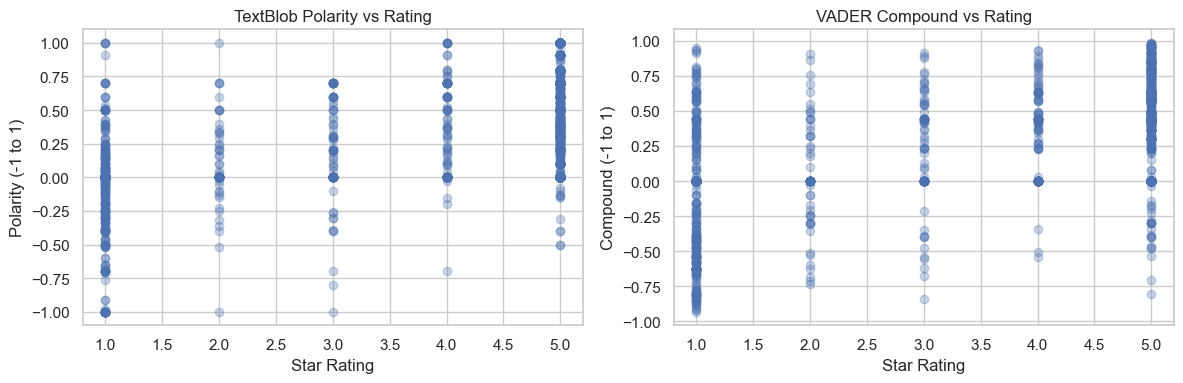

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# TextBlob: polarity vs rating
axes[0].scatter(df["rating"], df["tb_polarity"], alpha=0.3)
axes[0].set_title("TextBlob Polarity vs Rating")
axes[0].set_xlabel("Star Rating")
axes[0].set_ylabel("Polarity (-1 to 1)")

# VADER: compound vs rating
axes[1].scatter(df["rating"], df["vader_compound"], alpha=0.3)
axes[1].set_title("VADER Compound vs Rating")
axes[1].set_xlabel("Star Rating")
axes[1].set_ylabel("Compound (-1 to 1)")

plt.tight_layout()
plt.show()


# Aggrigation: Mean Sentiment by Bank and Rating

In [8]:
# Group by bank + rating
grouped = df.groupby(["bank_code", "rating"])

# Mean of BERT, TextBlob, VADER scores
sentiment_summary = (
    grouped[["sentiment_score_bert", "tb_polarity", "vader_compound"]]
    .mean()
    .reset_index()
)

# Add count of reviews in each group
sentiment_summary["n_reviews"] = grouped.size().values

sentiment_summary = sentiment_summary.sort_values(["bank_code", "rating"])
sentiment_summary

,bank_code,rating,sentiment_score_bert,tb_polarity,vader_compound,n_reviews
0,BOA,1,-0.814941,-0.108325,-0.166137,237
1,BOA,2,-0.751823,0.069643,0.045553,19
2,BOA,3,-0.266197,0.146931,0.147846,39
3,BOA,4,-0.095880,0.277892,0.339011,27
4,BOA,5,0.495062,0.422973,0.325563,278
5,CBE,1,-0.666644,-0.059865,-0.071478,85
6,CBE,2,-0.724484,0.108198,0.072991,23
7,CBE,3,-0.255583,0.174698,0.154359,27
8,CBE,4,0.088598,0.320570,0.311503,59
9,CBE,5,0.608247,0.463061,0.370337,406


## Visualization

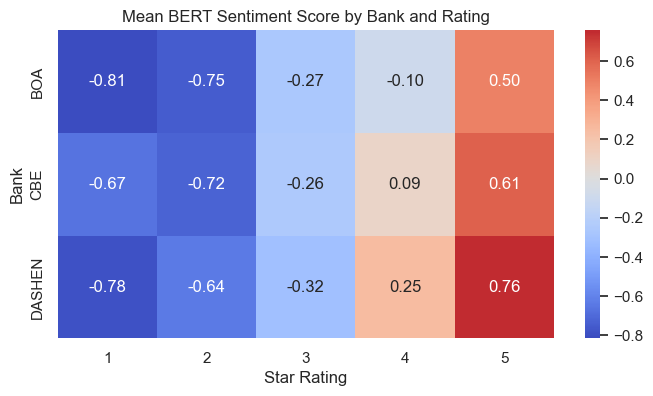

In [9]:
# Pivot for heatmap: BERT sentiment mean by bank and rating
pivot_bert = sentiment_summary.pivot(
    index="bank_code",
    columns="rating",
    values="sentiment_score_bert"
)

plt.figure(figsize=(8, 4))
sns.heatmap(pivot_bert, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Mean BERT Sentiment Score by Bank and Rating")
plt.xlabel("Star Rating")
plt.ylabel("Bank")
plt.show()
